In [240]:
# Import necessary libraries
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

#### This notebook follows the example in Research3/WAF_ML_Tutorial_Part2 but using data for the year 2000 stored in /pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/

# Make Data

## In terminal use cdo to select single level one year of data from daily data sets in:
/pl/active/ATOC_SynopticMet/data/ar_data/Research2/3hrly_merra2_hemisphere/


cdo -select,name=T 2000* T_2000.nc

cdo sellevel,950 T_2000.nc T950_2000.nc


# Resample the merra2 data for year 2000 to match CESM resolutions (also nicely decreases the size of the data)

In [35]:

def resample(file_name):
        fp = '/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/'
        data =  xr.open_mfdataset(fp+file_name)
        data = data.interp(lon = np.arange(-180,181,1), lat = np.arange(-90,1,1), time = pd.date_range("2000-01-01T00:00:00.000000000", periods= 1464, freq="6H"))
        data.to_netcdf(fp+'resize_'+file_name)

In [ ]:
# example, repeat this for whichever variables you want to use
resample('H500_2000.nc')

# Compile and format data for training (1, 2, 3)

## 1. feature data

In [263]:


H = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/resize_H500_2000.nc')
H = H.squeeze()
IWV = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/resize_IWV_2000')
LWTNET = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/resize_LWTNET_2000.nc')
SF = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/resize_SF200_2000')
SLP = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/resize_SLP_2000.nc')
T = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/resize_T950_2000.nc')
T = T.squeeze()
U = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/resize_U950_2000.nc')
U = U.squeeze()
V = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/resize_V950_2000.nc')
V = V.squeeze()

variable_times = T.time

H = np.array(H.H)
IWV = np.array(IWV.IWV)
LWTNET = np.array(LWTNET.LWTNET)
SF = np.array(SF.sf)
SLP = np.array(SLP.SLP)
T = np.array(T.T)
U = np.array(U.U)
V = np.array(V.V)

In [258]:
data = np.stack([H, IWV, LWTNET, SF, SLP, T, U, V])

## 2. 1D labeling - Is there an AR making landfall?

In [264]:
# category 1d label data: is there a landfalling AR or no

centers = pd.read_csv('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/ML_testing/ML_test_artimes_centers.csv')
centers = centers[pd.to_datetime(centers.AR_time)<pd.to_datetime('2001-01-01')]

ar_times = pd.to_datetime(np.array(centers.AR_time))

times_resampled = []
for i in range(len(ar_times)):
    if ar_times[i].hour in [0,6,12,18]:
        times_resampled.append(ar_times[i])
    else:
        times_resampled.append(ar_times[i] - pd.Timedelta(hours = 3))

ar_times_6hrly = pd.to_datetime(np.unique(times_resampled))
    
times = pd.DataFrame({'time':pd.to_datetime(np.array(variable_times))}).set_index('time')

times['AR_flag'] = np.zeros(len(times))
times.AR_flag[times.index.isin(ar_times_6hrly)] = 1

ar_flag = np.array(times.AR_flag)


## 3. 2d labeling, AR masks

In [393]:
# 2d label data: AR outlines
ar_catalog = xr.open_mfdataset('/projects/reba1583/Research2/data/AR_catalogue/2000.nc').sel(lat =slice(-90,0))
ar_catalog = ar_catalog.interp(lon = np.arange(-180,181,1), lat = np.arange(-90,1,1), time = pd.date_range("2000-01-01T00:00:00.000000000", periods= 1464, freq="6H"))

#this part is a little suspect- consider something different than the interpolation method above
ar_catalog = np.array(ar_catalog.ar_binary_tag)
ar_catalog[np.isnan(ar_catalog)] = 0
ar_catalog[ar_catalog>0] = 1
ar_catalog[ar_catalog<0] = 0

In [419]:
var_data = dict(
    features = (['n_channel', 'time', 'lat', 'lon' ], data),
    label_1d_AR = (['time'], ar_flag),
    label_2d_AR = (['time', 'lat', 'lon'], ar_catalog)
)

coords = dict(
    id = (['time'], ar_flag),
    n_channel = (['n_channel'], np.array(['H', 'IWV', 'LWTNET', 'SF', 'SLP', 'T', 'U', 'V'])),
    time = (['time'], pd.to_datetime(np.array(variable_times)))
    
)

ds = xr.Dataset(
    data_vars = var_data, 
    coords = coords
)

In [420]:

ds


<xarray.Dataset>
Dimensions:      (n_channel: 8, time: 1464, lat: 91, lon: 361)
Coordinates:
    id           (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  * n_channel    (n_channel) <U6 'H' 'IWV' 'LWTNET' 'SF' 'SLP' 'T' 'U' 'V'
  * time         (time) datetime64[ns] 2000-01-01 ... 2000-12-31T18:00:00
Dimensions without coordinates: lat, lon
Data variables:
    features     (n_channel, time, lat, lon) float32 5.058e+03 5.058e+03 ... nan
    label_1d_AR  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    label_2d_AR  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

## Plot one timestep of input data and AR Catalog

In [427]:
#define function 
def show_sample(ds):
    num_channels = len(ds_sample.n_channel)
    #define figure with 1 row and 5 columns. 
    fig,axes = plt.subplots(num_channels+1,1,figsize=(10, num_channels*5))
    #set the background to white, for some reason its transparent
    fig.set_facecolor('w')
    #choose some colormaps for drawing
    cmaps = ['Blues','turbo','Spectral_r','Greys_r', 'Blues','turbo','Spectral_r','Greys_r', 'Blues','turbo','Spectral_r','Greys_r']
    #loop over features (inputs)
    for i,ax in enumerate(axes[0:num_channels]):
        #plot images
        ax.imshow(ds.isel(n_channel = i).features,cmap=cmaps[i])
        ax.axis('off')
        ax.set_title(ds.n_channel[i].values)

    #plot labels (output) which is GLM 
    ax = axes[num_channels]
    ax.imshow(ds.label_2d_AR[:,:],cmap='magma')
    ax.axis('off')
    ax.set_title('glm')

#     fig.suptitle('class label: {}, n flashes: {}'.format(ds.label_1d_class.values,ds.label_1d_reg.values),y=0.75)

    return ds.id.values

array(0.)

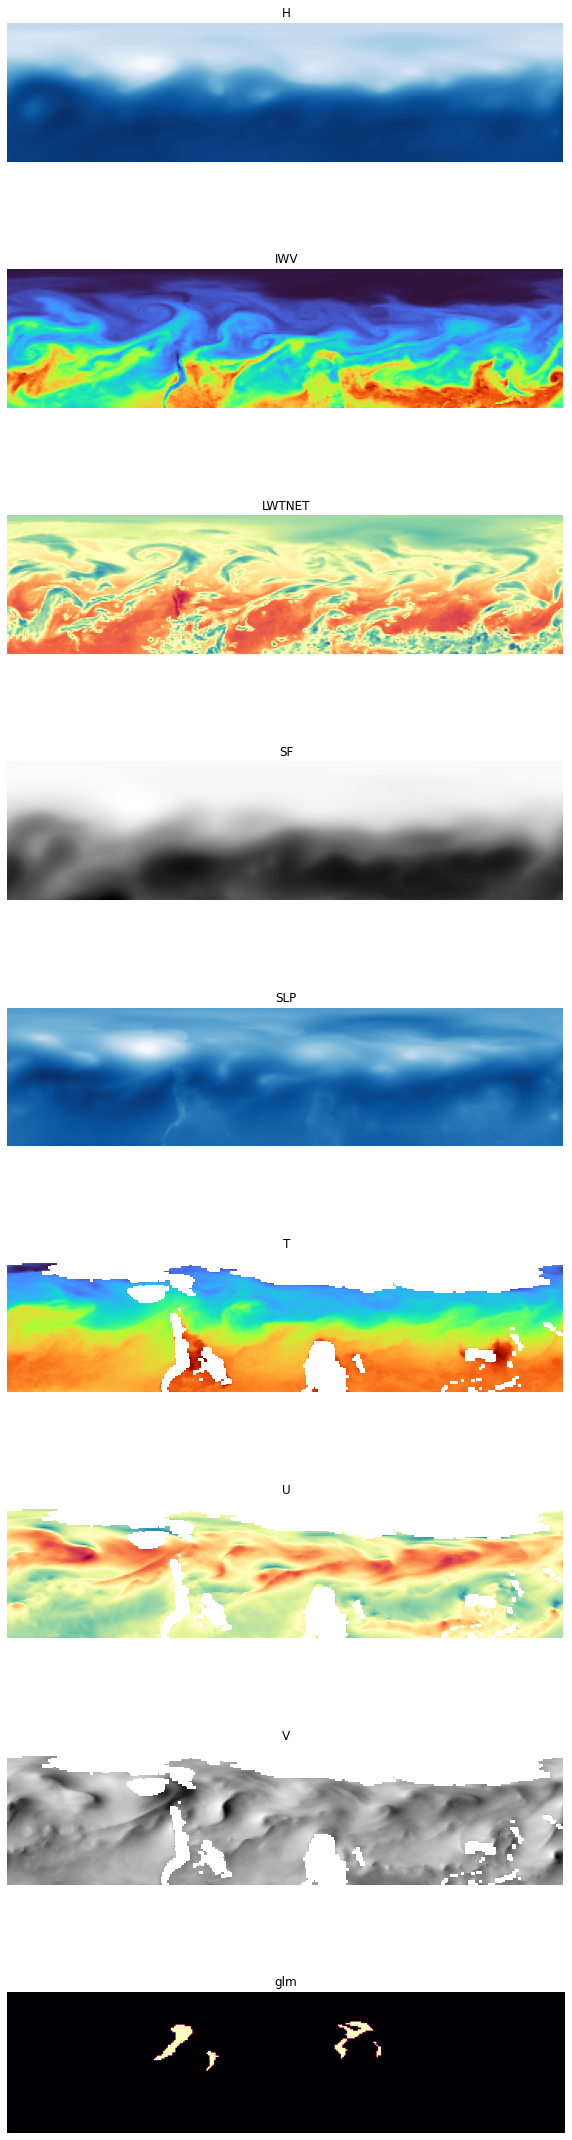

In [429]:
ds_sample = ds.isel(time = 95)
show_sample(ds_sample)